**Problem statement**: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [2]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
## Mounting the google drive:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2363 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

## Importing Skin Cancer Data

In [4]:
# Defining the path for train and test images
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path('/content/gdrive/MyDrive/Test')

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2245
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Defining some parameters for the loader as per details given in problem:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Using 80% of the images for training, and 20% for validation.

In [7]:
## Train Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    subset = "training",
    image_size = (img_height,img_width),
    batch_size = batch_size)

Found 2245 files belonging to 9 classes.
Using 1796 files for training.


In [8]:
## Validation Dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed = 123,
    validation_split=0.2,
    subset = "validation",
    image_size = (img_height,img_width),
    batch_size = batch_size)

Found 2245 files belonging to 9 classes.
Using 449 files for validation.


In [9]:
## Listing out all the classes of skin cancer and storing them as a list
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


## Visualize the Data

32
32


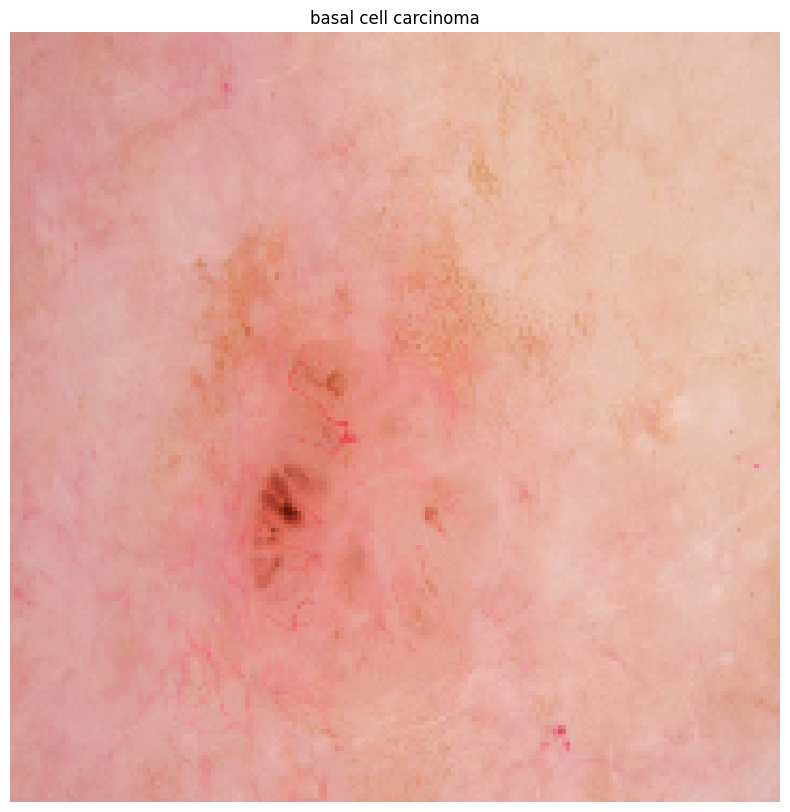

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  print(len(images))
  print(len(labels))
  plt.imshow(images[0].numpy().astype("uint8"))
  plt.title(class_names[labels[0]])
  plt.axis("off")

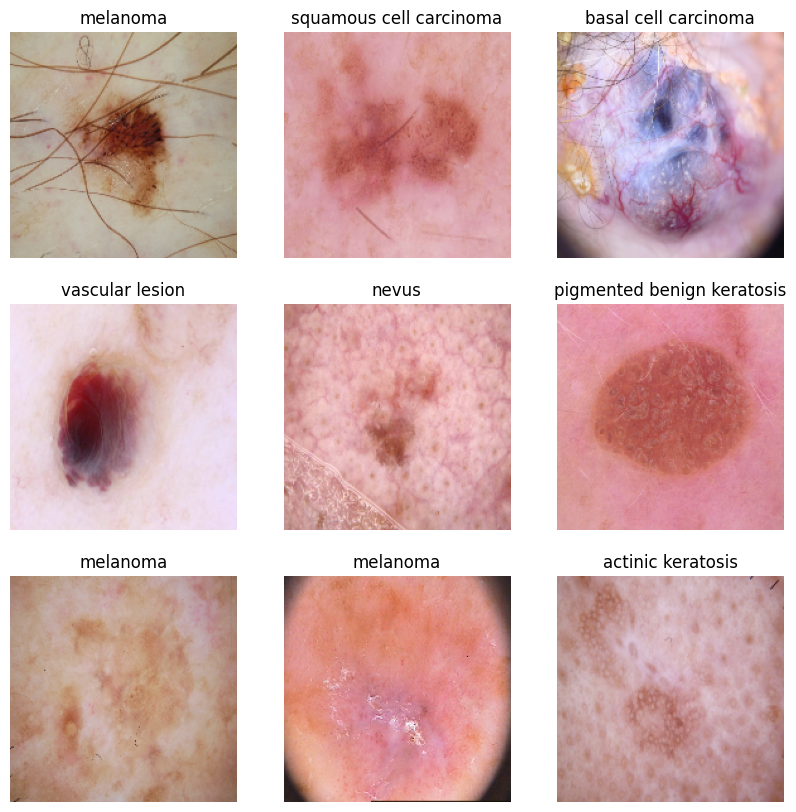

In [11]:
plt.figure(figsize=(10,10))
for images,labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Creating the Vanilla model

In [13]:
num_classes = 9

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

## Compiling the model

In [14]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

## Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 426s 2s/step - loss: 2.0843 - accuracy: 0.2144 - val_loss: 1.9392 - val_accuracy: 0.3296
Epoch 2/20
57/57 [==============================] - 1s 22ms/step - loss: 1.8687 - accuracy: 0.3235 - val_loss: 1.8223 - val_accuracy: 0.3675
Epoch 3/20
57/57 [==============================] - 1s 22ms/step - loss: 1.5944 - accuracy: 0.4560 - val_loss: 1.5050 - val_accuracy: 0.4833
Epoch 4/20
57/57 [==============================] - 1s 22ms/step - loss: 1.3646 - accuracy: 0.5145 - val_loss: 1.3257 - val_accuracy: 0.5412
Epoch 5/20
57/57 [==============================] - 1s 19ms/step - loss: 1.2315 - accuracy: 0.5685 - val_loss: 1.3190 - val_accuracy: 0.5323
Epoch 6/20
57/57 [==============================] - 1s 20ms/step - loss: 1.2183 - accuracy: 0.5757 - val_loss: 1.3326 - val_accuracy: 0.5323
Epoch 7/20
57/57 [==============================] - 1s 20ms/step - loss: 1.1215 - accuracy: 0.6063 - val_loss: 1.4063 - val_accuracy: 0.5212
Epoch 8/20
57

## Visualizing the training result

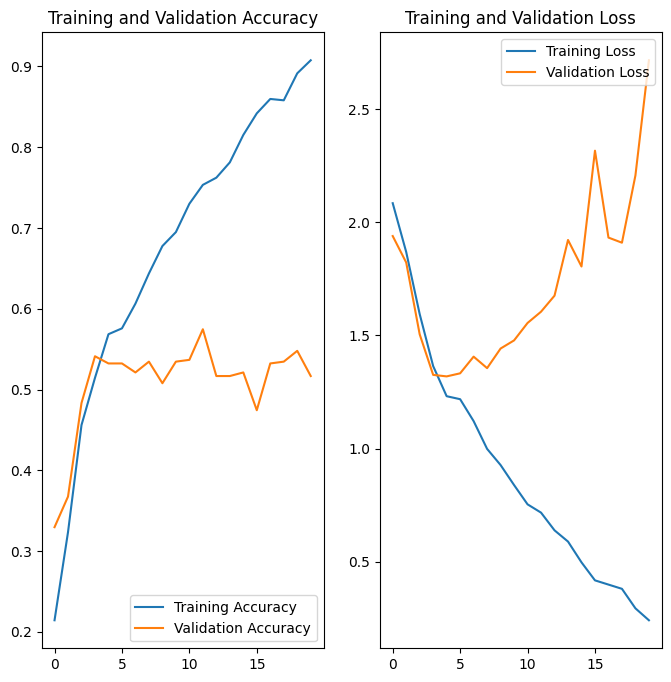

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analysis 1** <br>
There is a noticable difference between training and validation accuracy. Training accuaracy is close to 90% whereas validation accuarcy is close to 50% only.It signifies that there is overfitting.

## Data Augmentation

In [18]:
data_augmentation = keras.Sequential(
  [
    layers.experimental.preprocessing.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomCrop(img_height,img_width),
    layers.experimental.preprocessing.RandomContrast(0.1)
  ]
)

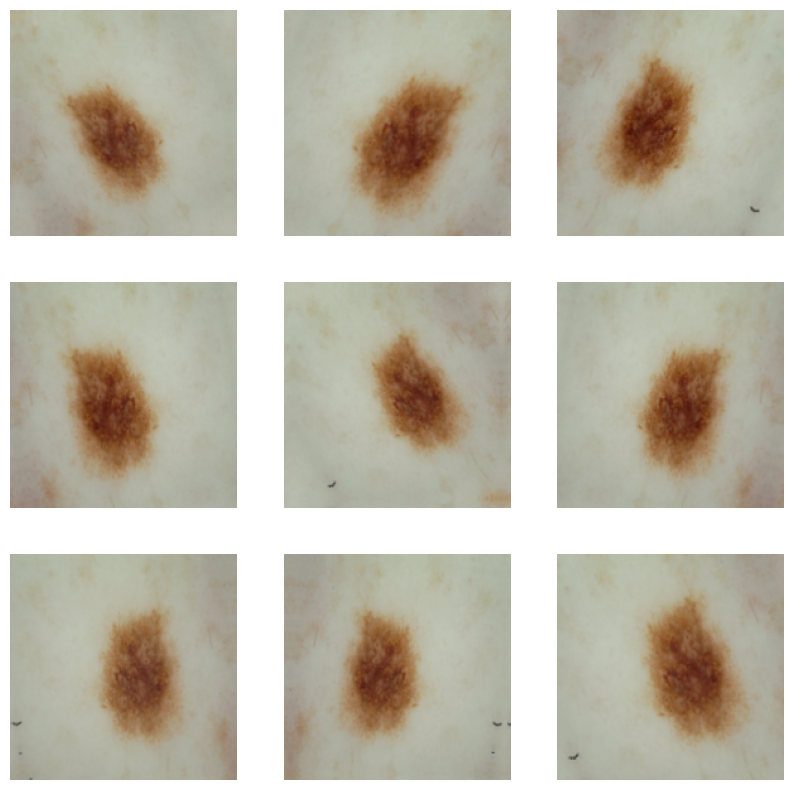

In [19]:
## Visualizing how the data augmentation strategy works
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

## Creating Vanilla model after data augmentation

In [25]:
# Using Dropout as it is a case of overfitting
model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compiling the model

In [26]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## Training the model with 20 epochs

In [27]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
57/57 [==============================] - 4s 36ms/step - loss: 2.0483 - accuracy: 0.2528 - val_loss: 1.9021 - val_accuracy: 0.2650
Epoch 2/20
57/57 [==============================] - 2s 31ms/step - loss: 1.7450 - accuracy: 0.3714 - val_loss: 1.6042 - val_accuracy: 0.4521
Epoch 3/20
57/57 [==============================] - 2s 31ms/step - loss: 1.6072 - accuracy: 0.4215 - val_loss: 1.5460 - val_accuracy: 0.4543
Epoch 4/20
57/57 [==============================] - 2s 31ms/step - loss: 1.5135 - accuracy: 0.4543 - val_loss: 1.5304 - val_accuracy: 0.4610
Epoch 5/20
57/57 [==============================] - 2s 30ms/step - loss: 1.4162 - accuracy: 0.5033 - val_loss: 1.5083 - val_accuracy: 0.4722
Epoch 6/20
57/57 [==============================] - 2s 33ms/step - loss: 1.4526 - accuracy: 0.4916 - val_loss: 1.4244 - val_accuracy: 0.4967
Epoch 7/20
57/57 [==============================] - 2s 37ms/step - loss: 1.4000 - accuracy: 0.5045 - val_loss: 1.2945 - val_accuracy: 0.5434
Epoch 8/20
57

## Visualizing the results

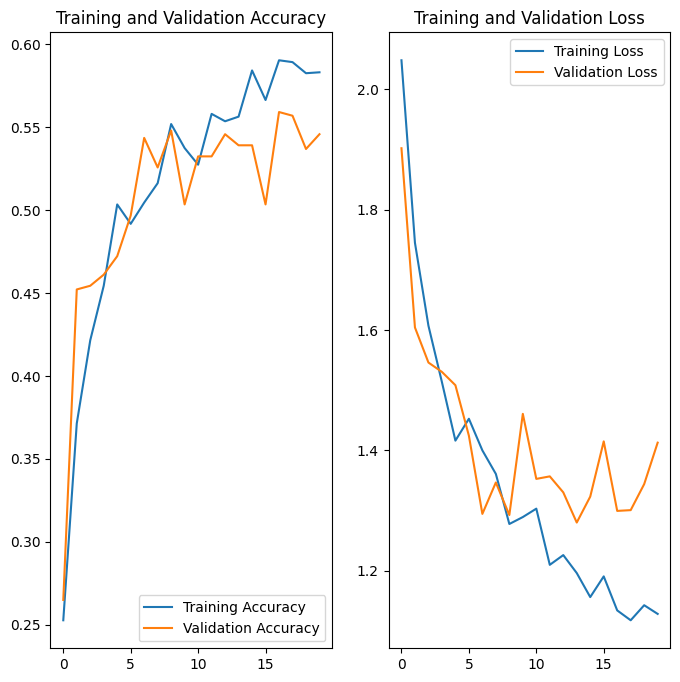

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analysis 2**: <br>
The training and validation accuaracy are almost same. However, the accuaracy are quite low. The model needs to be trained with more number of epochs after handling of class imbalance if any.

## Checking distribution of classes in Training dataset

In [29]:
def class_distribution_count(directory):

    #count number of image in each classes
    count= []
    for path in pathlib.Path(directory).iterdir():
        if path.is_dir():
            count.append(len([name for name in os.listdir(path)
                               if os.path.isfile(os.path.join(path, name))]))

    #name of the classes
    sub_directory = [name for name in os.listdir(directory)
                    if os.path.isdir(os.path.join(directory, name))]

    #return dataframe with image count and class.
    return pd.DataFrame(list(zip(sub_directory,count)),columns =['Class', 'No. of Image'])

df = class_distribution_count(data_dir_train)
df

,Class,No. of Image
0,nevus,357
1,pigmented benign keratosis,468
2,dermatofibroma,95
3,vascular lesion,139
4,squamous cell carcinoma,181
5,melanoma,438
6,basal cell carcinoma,376
7,actinic keratosis,114
8,seborrheic keratosis,77


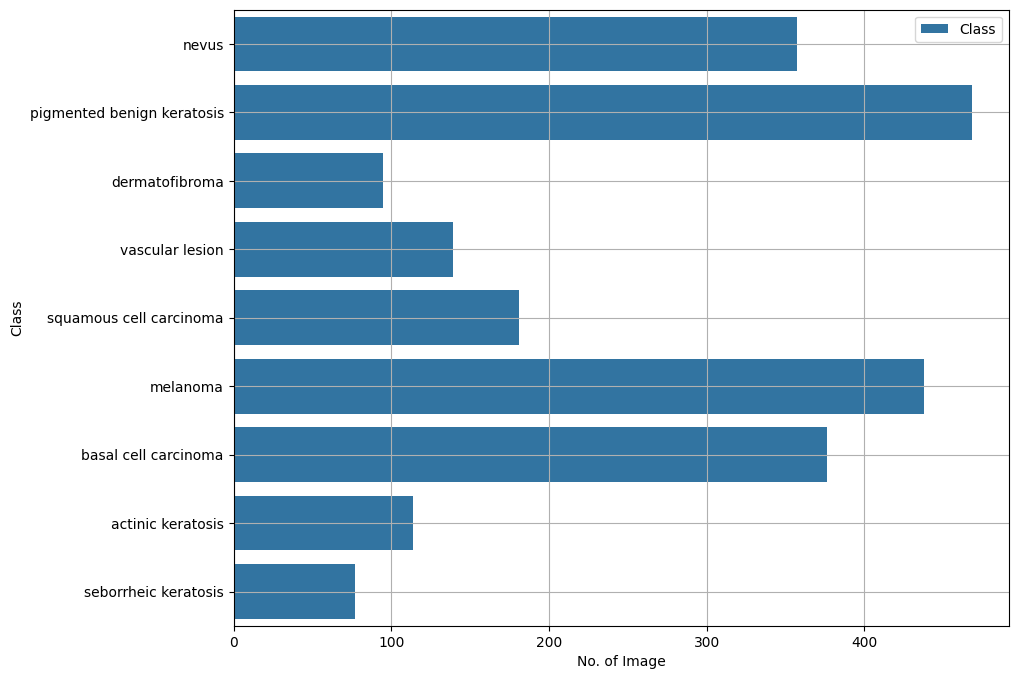

In [30]:
#Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Image", y="Class", data=df, label="Class")
plt.grid()

**There is class imbalance in dataset.** <br>

**Seborrheic Keratosis** class has the least number of samples

**pigmented benign keratosis** class dominate the data in terms proportionate number of samples followed by **melanoma**.

## Rectifying class imbalance

In [31]:
!pip install Augmentor

In [32]:
## We are adding 500 samples per class to make sure that none of the classes are sparse.
path_to_training_dataset = "/content/gdrive/MyDrive/Train/"
import Augmentor
for i in class_names:
  p = Augmentor.Pipeline(path_to_training_dataset + i)
  p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
  p.sample(500)

Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791FDADEAD70>: 100%|██████████| 500/500 [00:24<00:00, 20.49 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x791FDA4066E0>: 100%|██████████| 500/500 [00:18<00:00, 26.91 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791FDAD0FE50>: 100%|██████████| 500/500 [00:20<00:00, 24.99 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=2048x1536 at 0x791FDA414A90>: 100%|██████████| 500/500 [01:33<00:00,  5.33 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=919x802 at 0x7920A212C5B0>: 100%|██████████| 500/500 [01:28<00:00,  5.67 Samples/s]


Initialised with 468 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x792128C74F10>: 100%|██████████| 500/500 [00:19<00:00, 25.77 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x791FE31B4700>: 100%|██████████| 500/500 [00:45<00:00, 11.02 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x792094204AF0>: 100%|██████████| 500/500 [00:18<00:00, 27.71 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x791FDAD497E0>: 100%|██████████| 500/500 [00:19<00:00, 25.04 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
from glob import glob
path_list = [x for x in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0000051.jpg_cd6bfef3-3e04-4c03-ac95-5cf1a3547e71.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0027950.jpg_60d24b57-4f3d-421b-b41e-f9f3541ab2ca.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0029041.jpg_dc170677-d525-4bdb-b268-7e0efa058b4b.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0000486.jpg_32569db3-60ae-43e6-a172-cc29ecd478f5.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0028190.jpg_516205e5-bf30-4dd9-89e2-b84ecb11e1da.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0000503.jpg_2b99b1ba-567f-4eee-92d6-1eb9389075ba.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0000507.jpg_37227f43-c4b2-4911-931a-2e37cce7a4b1.jpg',
 '/content/gdrive/MyDrive/Train/nevus/output/nevus_original_ISIC_0029460.jpg_a3eb676a-6ed2-40f6-b8a0-a77863a4cc4d.jpg',
 '/content/gdrive/MyDrive/Train/nevus/ou

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

['nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',
 'nevus',


In [36]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [37]:
for i in class_names:
    directory ='images/Train'
    directory_out ='images/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 0 samples.
basal cell carcinoma has 0 samples.
dermatofibroma has 0 samples.
melanoma has 0 samples.
nevus has 0 samples.
pigmented benign keratosis has 0 samples.
seborrheic keratosis has 0 samples.
squamous cell carcinoma has 0 samples.
vascular lesion has 0 samples.


## Creating the model on data set created using Augmentor

## Creating training and validation dataset

In [38]:
batch_size = 32
img_height = 180
img_width = 180

In [39]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6745 files belonging to 9 classes.
Using 5396 files for training.


In [40]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6745 files belonging to 9 classes.
Using 1349 files for validation.


In [41]:
model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255,input_shape=(180,180,3)))
model.add(layers.Conv2D(32,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(64,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Conv2D(256,kernel_size=(11,11),activation='relu'))
model.add(layers.MaxPool2D(pool_size=(2,2)))
model.add(layers.Dropout(0.5))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(128,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64,activation='relu'))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(len(class_names),activation='softmax'))

## Compiling the model

In [42]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [43]:
# View the summary of all layers
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 41, 41, 128)      

## Training the model

In [44]:
epochs = 30
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


169/169 [==============================] - 52s 264ms/step - loss: 2.0823 - accuracy: 0.1953 - val_loss: 1.8315 - val_accuracy: 0.2898
Epoch 2/30
169/169 [==============================] - 52s 302ms/step - loss: 1.7853 - accuracy: 0.3000 - val_loss: 1.6321 - val_accuracy: 0.3721
Epoch 3/30
169/169 [==============================] - 44s 251ms/step - loss: 1.6322 - accuracy: 0.3658 - val_loss: 1.5059 - val_accuracy: 0.4225
Epoch 4/30
169/169 [==============================] - 44s 256ms/step - loss: 1.5709 - accuracy: 0.3871 - val_loss: 1.5257 - val_accuracy: 0.4136
Epoch 5/30
169/169 [==============================] - 43s 245ms/step - loss: 1.4812 - accuracy: 0.4198 - val_loss: 1.5252 - val_accuracy: 0.4322
Epoch 6/30
169/169 [==============================] - 43s 247ms/step - loss: 1.4286 - accuracy: 0.4346 - val_loss: 1.2604 - val_accuracy: 0.5056
Epoch 7/30
169/169 [==============================] - 45s 256ms/step - loss: 1.4111 - accuracy: 0.4570 - val_loss: 1.2272 - val_accuracy: 0.5

## Visualizing the results

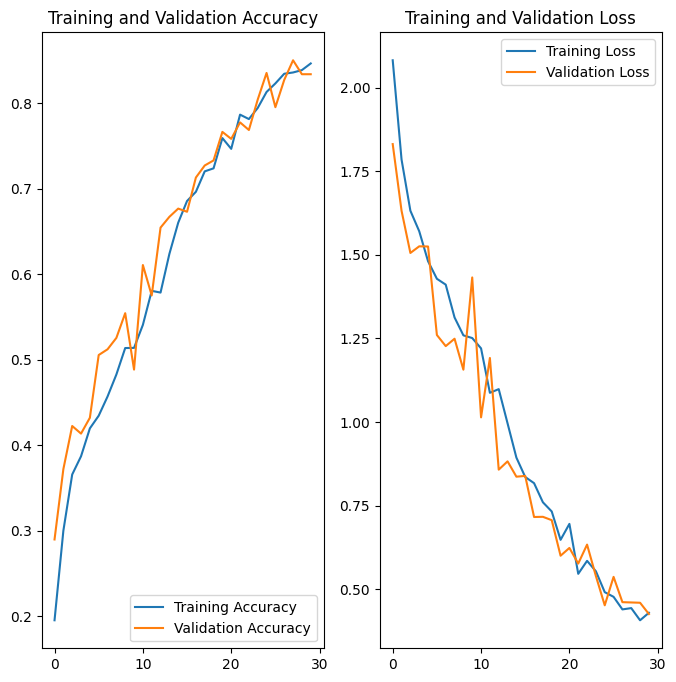

In [45]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Analysis 3 :** <br>
The accuracy of both Training and and validation dataset has incresed. The differnce in acurracy between the two is also negligible.
 The 3rd model with class imbalance handling and increased number of epochs seems to be a good model.